**Part 6: Linear regression with outliers removed**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In part 1 we performed a linear regression using only the 34 numerical features. In part 2 we transformed 22 categorical features into numerical features via transformations, and performed a linear regression on the enlarged set of numerical features, 56 in total. In part 3 we removed those categorical values which we believe contain little information, incorporated the remaining categorical features using one-hot encoding, and performed a linear regression on the result. In part 4 removed features which were weakly correlated with the train sale price in an attempt to reduce noise. In part 5 we removed features which are strongly correlated with each other in a different attempt to reduce noise. Here we try to identify 'outliers' and eliminate them, again in an attempt to reduce noise.

'outliers' refer to particular house data in train for which we reason to be 'far away' from the average behaviour. Removing these, we hope that the remaining house data in train is 'closer' to the average behaviour, and that an estimate based only on that data will be more accurate. There are many ways we might attempt to do this, both manually and with automated tools, but we will keep things simple by restricting to 'outlier' sale prices.

We begin by reproducing steps 1-3 of part 3. We do not remove any weak correlations (as in part 4) or strong correlations (as in part 5) as we want to examine the effect of removing the outliers by themselves.

**Step 1: Reproduce steps 1-3 of part 3**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)

# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


56
(1460, 213)
(1459, 213)


As a reminder, numeric_features_columns represents the extended set of 56 numerical features: The original 34 numerical features (part 0), and the 22 categorical features that we converted into numerical features via transformations (part 2). The other 157 = 213-56 numerical features were constructed from the categorical features via one-hot encoding (part 3).

**Step 2: Outlier train sale price data**

What we do here is very simple: Looking back on our results with train test splits in parts 3 and 4 and 5, and in particular looking at the graphs of our predicted log sale prices vs the actual log sale prices, we see that we see that we are not predicting large or small sale prices well. So we will simply eliminate those houses in the train dataset.

Similar to step 5 of part 0, we will use the MinMaxScaler to create a scaled train SalePrice dataframe with values which lie between 0 and 1. Scaled prices close to 1 are large house prices, and scaled prices close to 0 are small house prices. We will remove houses whose scaled prices are between 0.85 and 1, and between 0 and 0.15. How many train house sale prices satisfy these conditions?

In [2]:
X = train.copy() # The train feature data
Y = train_sale_price.copy() # The train sale price data

Y_array = np.array(Y) # A simple array with the train SalePrice data
Y_scaler = MinMaxScaler() # Initialise salePrice scaler
Y_scaler.fit(Y_array) # Fit scaler to array
Y_scaled = pd.DataFrame(Y_scaler.transform(Y_array), columns = ['SalePrice']) # Create scaled train salePrice dataframe

print(Y.shape)
print(Y[Y_scaled['SalePrice'] >= 0.85].shape)
print(Y[Y_scaled['SalePrice'] <= 0.15].shape)

(1460, 1)
(10, 1)
(9, 1)


There are 1460 total train rows (individual train house data), 10 scaled house prices between 0.85 and 1, and 9 between 0 and 0.15. We will remove these.

**Step 3: Linear regression**

First the train-test split. We do the train-test split before removing the outliers, as the outliers should be removed from x_train and y_train, but not removed from x_test and y_test. This is because we calculate the linear regression using x_train and y_train, and score it on x_test and y_test, and a fair score can only be obtained if the test data is unchanged.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test
number_of_values_to_predict = actual_log_prices.shape[0]

print(number_of_values_to_predict)
actual_log_prices.head()

482


,SalePrice
892,11.947949
1105,12.691580
413,11.652687
522,11.976659
1036,12.661914


Next, remove the outlier sale price data from X and Y, and from x_train and y_train, but not x_test and y_test.

In [4]:
Y = Y[Y_scaled['SalePrice'] < 0.85] # Remove all house data/rows from Y (the train SalePrice data) for which the scaled SalePrice has value between 0.85 and 1
Y = Y[Y_scaled['SalePrice'] > 0.15] # Remove all house data/rows from Y (the train SalePrice data) for which the scaled SalePrice has value between 0 and 0.15
Y_indices = list(Y.index) # List of the remaining rows indices of Y after removal of the above
X = X[X.index.isin(Y_indices)] # Remove the rows from X (the train feature data) that have been removed from Y

print('The number of remaining house data after removing outlier sale price data equals ' + str(X.shape[0]))

x_train = x_train[x_train.index.isin(Y_indices)] # Remove the rows from x_train that have been removed from Y
y_train = y_train[y_train.index.isin(Y_indices)] # Remove the rows from x_test that have been removed from Y

The number of remaining house data after removing outlier sale price data equals 1441


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


We reduced the train house data from 1460 to 1441. Next the linear regression using x_train and y_train, scored with x_test and y_test.

0.1484727051463123


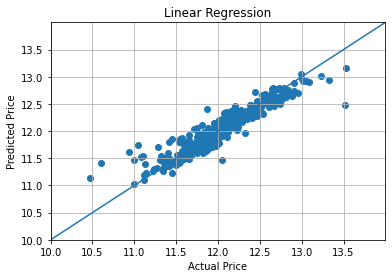

In [5]:
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show()

Next the linear regression using the whole of X and Y.

In [6]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14110**.

**Step 4: Linear regression with only the extended numeric set, no one-hot encoding**

Recall that the extended set of numerical set contained 56 features. Here we perform the linear regression using only these 56 numerical features, and so we ignore the one-hot encoded categorical features.

First the train-test split.

0.15217574065222603


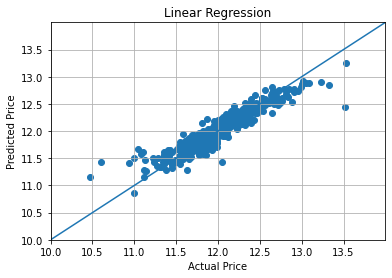

In [7]:
X = X[numeric_features_columns]
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]
# Y and y_train and y_test are are unchanged from above

model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next linear regression using the whole of X and Y.

In [8]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns] 
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting this file to kaggle gives a **RMSE score of 0.15117**.

**Step 5: Outlier train feature data which are 'far from typical'** 

Now, instead of tring to identify and remove outlier train sale price data, we will attempt to identify and remove house train data whose numerical features are 'far from typical'. We begin by reproducing step 1 above.

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)

# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


56
(1460, 213)
(1459, 213)


Now we give scatter plots for the 56 features in numeric_features_columns vs the sale price. First, however, similar to step 5 of part 0, and Y_scaled above, we use the MinMaxScaler to create a scaled train numeric dataframe with values which lie between 0 and 1. Again the is no need to recalculate Y_scaled as we have done so above.

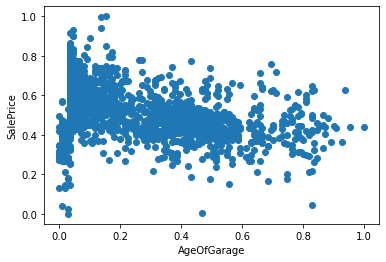

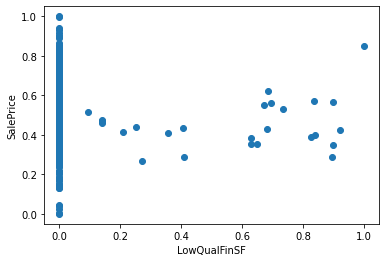

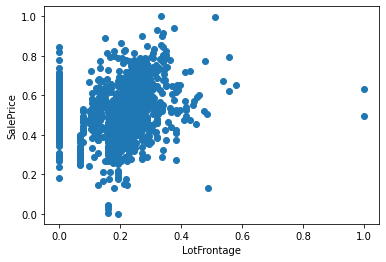

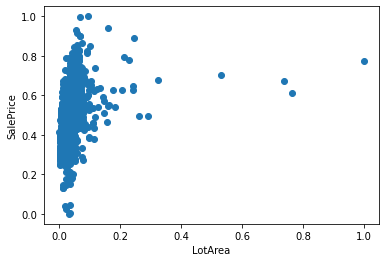

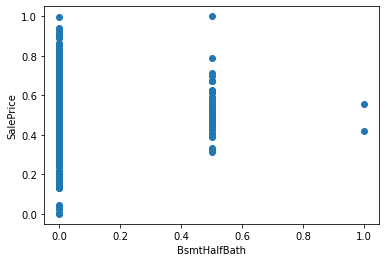

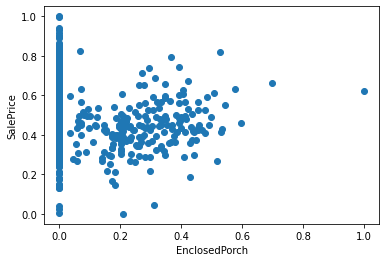

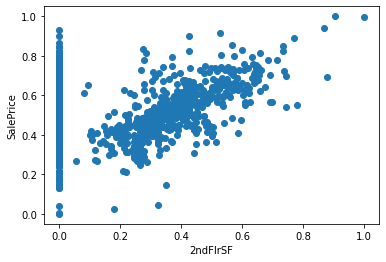

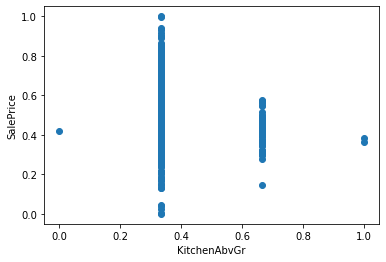

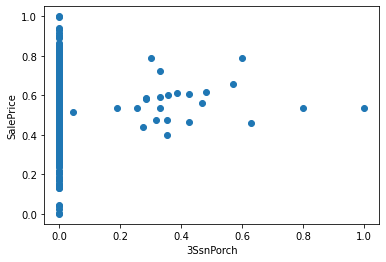

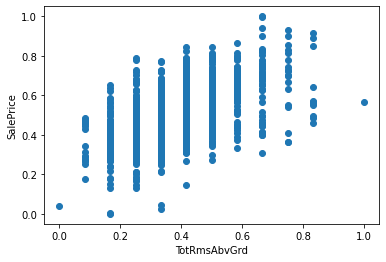

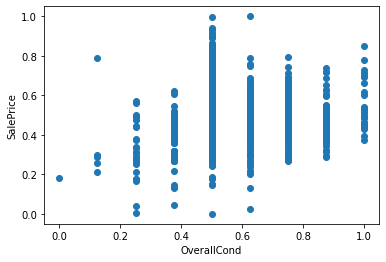

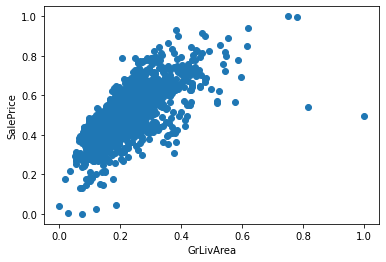

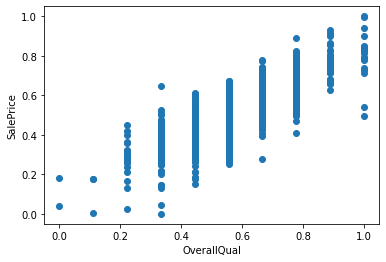

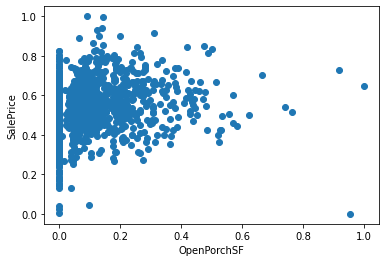

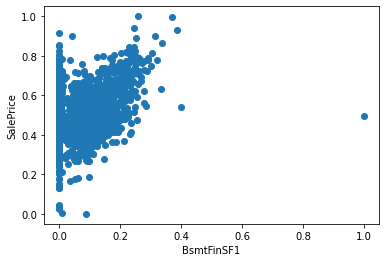

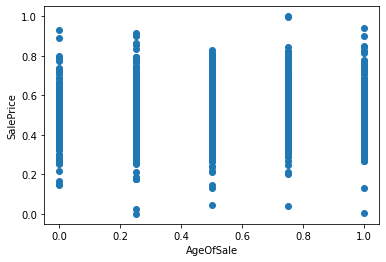

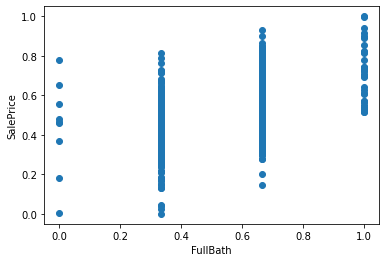

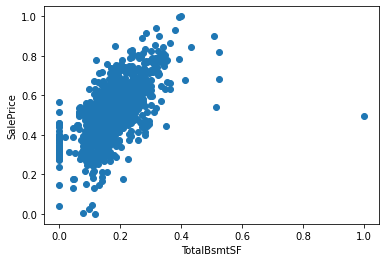

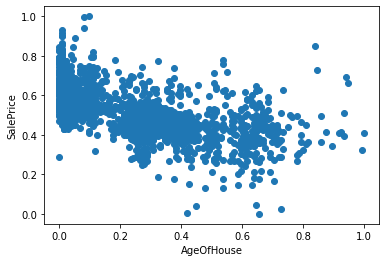

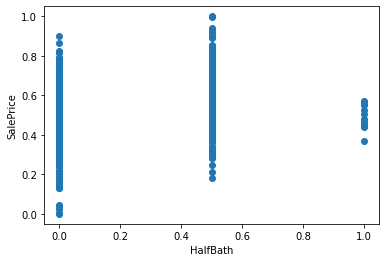

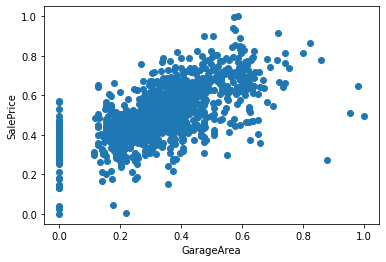

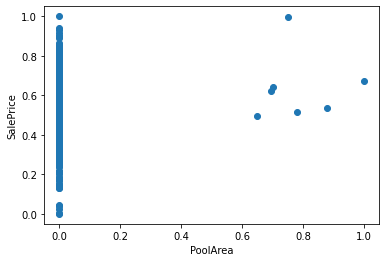

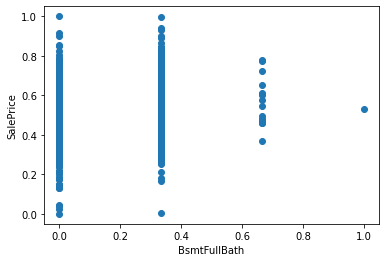

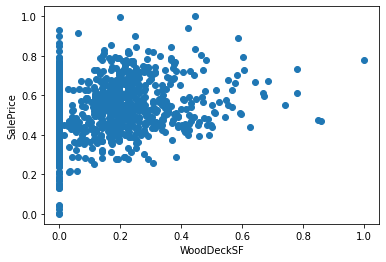

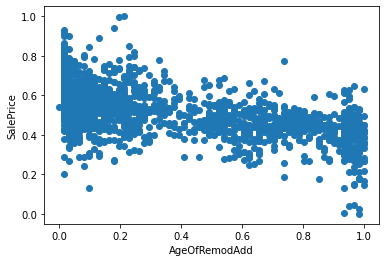

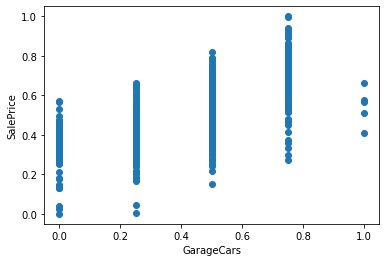

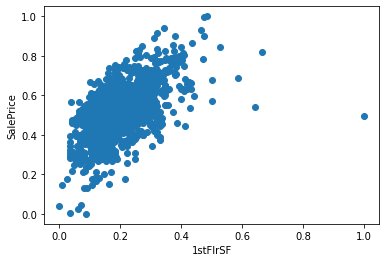

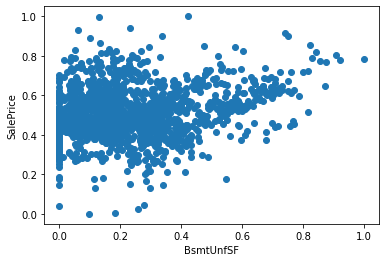

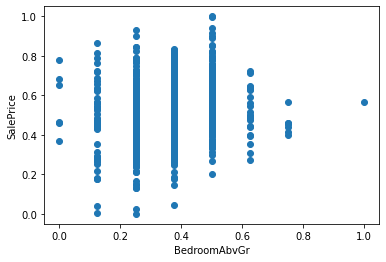

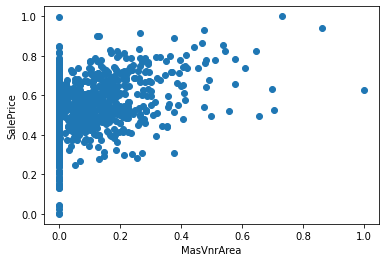

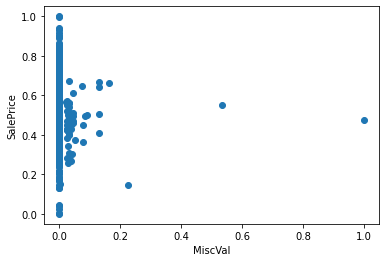

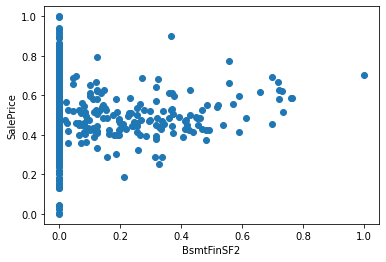

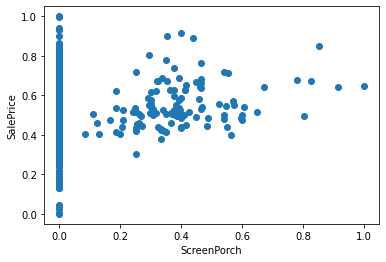

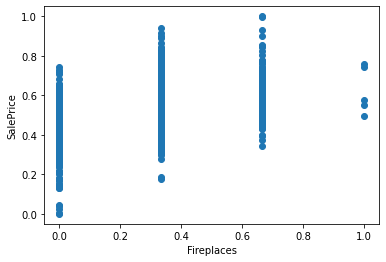

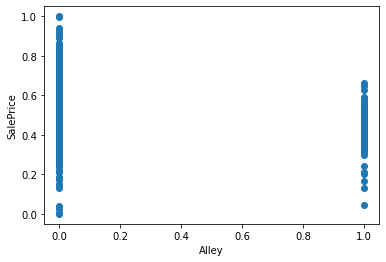

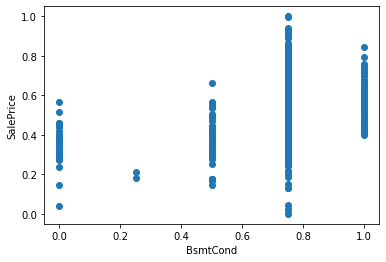

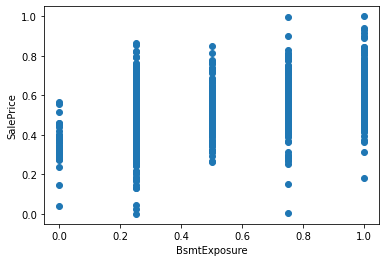

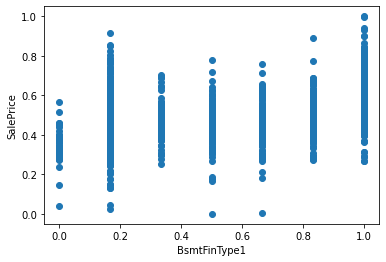

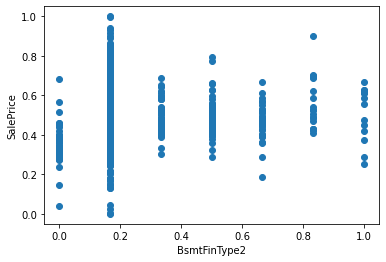

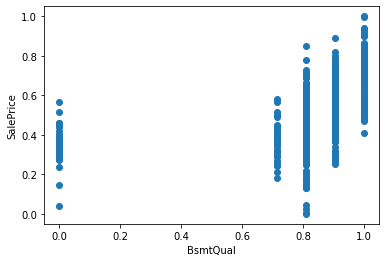

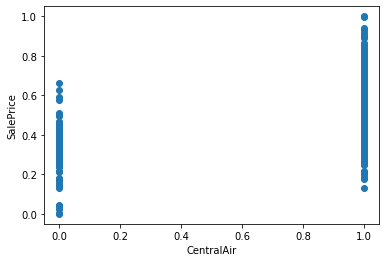

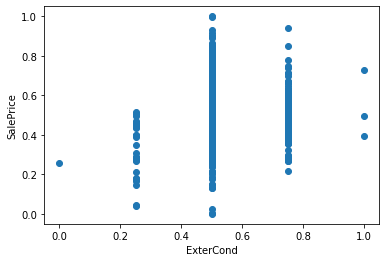

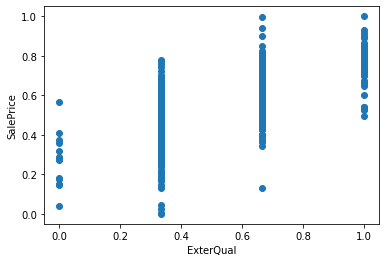

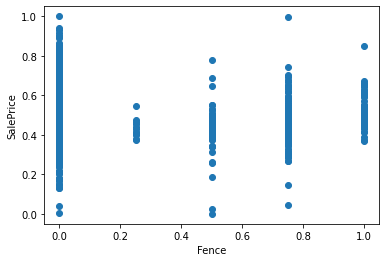

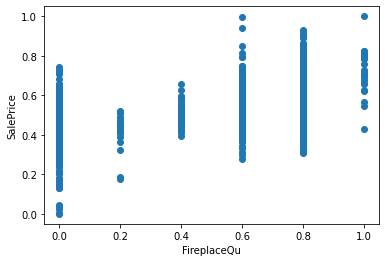

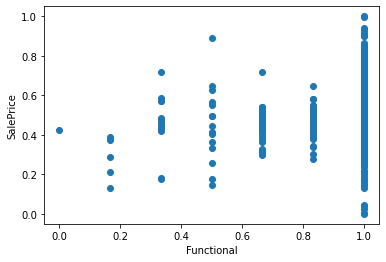

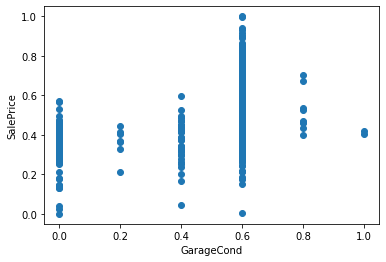

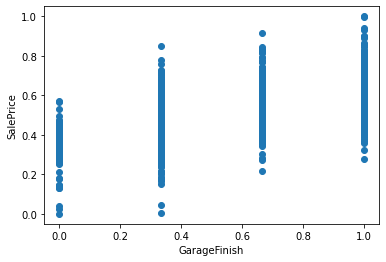

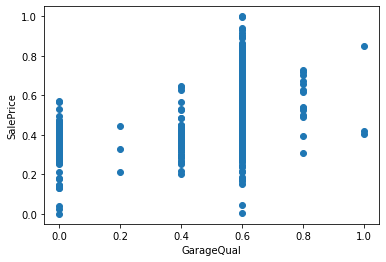

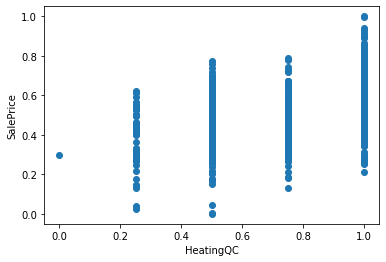

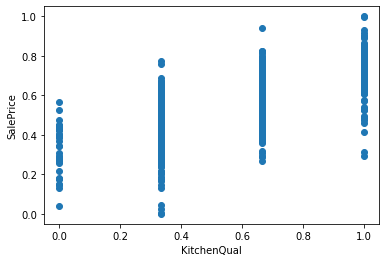

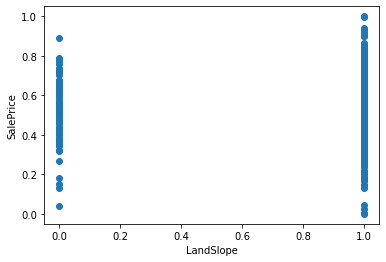

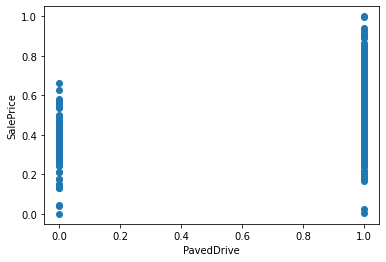

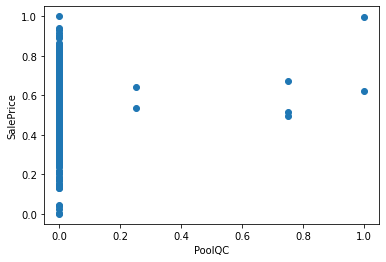

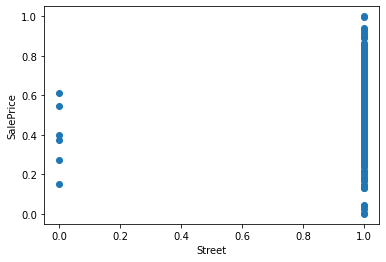

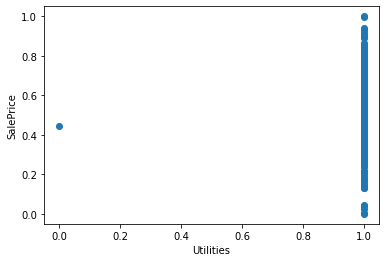

In [10]:
X = train.copy() # The train feature data
Y = train_sale_price.copy() # The train sale price data

X_numeric_array = np.array(X[numeric_features_columns]) # A simple array with only the numeric train features
X_numeric_scaler = MinMaxScaler() # Initialise scaler
X_numeric_scaler.fit(X_numeric_array) # Fit scaler to array
X_numeric_scaled = pd.DataFrame(X_numeric_scaler.transform(X_numeric_array), columns = numeric_features_columns) # Create a dataframe with the scaled train numeric features

from matplotlib import pyplot as plt

for item in numeric_features_columns: # Scatter plots of the scaled train numeric features vs train scaled SalePrice
    plt.scatter(x=X_numeric_scaled[item], y=Y_scaled['SalePrice'])
    plt.ylabel('SalePrice')
    plt.xlabel(item)
    plt.show()

'Far from typical outliers' can intuitively be understood to be those house feature values which are 'very far' from the greatest concentrations in the above plots. We do the identification of these manually and intuitively. For example, in scaled SalePrice vs LotArea, those scaled LotAreas with values greater that 0.3 seem far from the greatest concentrations. Lets remove these and plot the result.

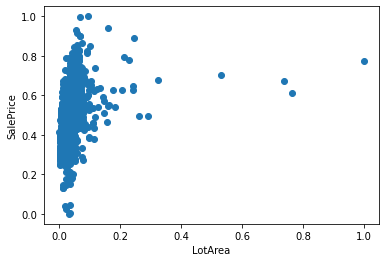

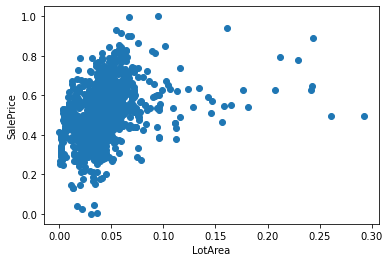

In [11]:
X_with_LotArea_outliers_removed = X_numeric_scaled[X_numeric_scaled['LotArea'] < 0.3] # Create a dataframe with the scaled train numeric features with the following removed: All house data/rows for which the scaled train LotArea has value between 0.3 and 1
Y_with_LotArea_outliers_removed = Y_scaled[Y_scaled.index.isin(list(X_with_LotArea_outliers_removed.index))] # Create a dataframe with the scaled train train SalePrice with the same house data/rows removed as above

plt.scatter(x=X_numeric_scaled['LotArea'], y=Y_scaled['SalePrice']) # Scatter plot of the scaled train LotArea vs train scaled SalePrice with outliers present
plt.ylabel('SalePrice')
plt.xlabel('LotArea')
plt.show()

plt.scatter(x=X_with_LotArea_outliers_removed['LotArea'], y=Y_with_LotArea_outliers_removed['SalePrice']) # Scatter plot of the scaled train LotArea vs train scaled SalePrice with outliers removed
plt.ylabel('SalePrice')
plt.xlabel('LotArea')
plt.show()

Still not quite concentrated, but better than before. Maybe. We do something similar for the remaining numeric features, where we think appropriate. There is a lot of guess work in this. First, as in step 3, we do the train test split.

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


The number of remaining house data after removing far from typical outliers equals 1422
0.12746823004040822


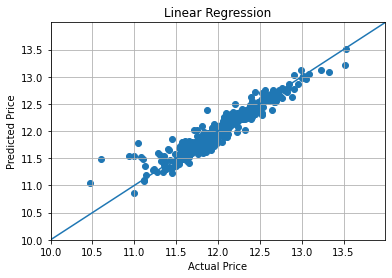

In [12]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test
number_of_values_to_predict = actual_log_prices.shape[0]

far_from_typical_outliers_with_bounds = [
    ('LotArea', 0.3),
    ('LotFrontage', 0.65),
    ('MasVnrArea', 0.85),
    ('BsmtFinSF1', 0.35),
    ('TotalBsmtSF', 0.5),
    ('2ndFlrSF', 0.75),
    ('1stFlrSF', 0.45),
    ('GrLivArea', 0.8),
    ('BsmtFullBath', .8),
    ('TotRmsAbvGrd', 1),
    ('GarageArea', 0.75),
    ('OpenPorchSF', 0.75),
    ('MiscVal', 0.25)
] # List of all the features for which we have chosen to remove 'far from typical outliers', paired with the scaled values above which we remove. For example, ('LotArea', 0.3) means we remove house house data for which the scaled LotArea is between 0.225 and 1

# Remove the far from typical outliers from X and Y, and from x_train and y_train, but not x_test and y_test.
for (feature, value_bound) in far_from_typical_outliers_with_bounds: # For each feature in the list
    X = X[X_numeric_scaled[feature] < value_bound] # Remove all house data/rows from X (the train feature data) for which that feature has scaled value between value_bound and 1
X_indices = list(X.index) # List of the remaining rows indices of X after removal of the above
Y = Y[Y.index.isin(X_indices)] # Remove the rows from Y (the train SalePrice data) that have been removed from X

print('The number of remaining house data after removing far from typical outliers equals ' + str(X.shape[0]))

x_train = x_train[x_train.index.isin(X_indices)] # Remove the rows from x_train that have been removed from X
y_train = y_train[y_train.index.isin(X_indices)] # Remove the rows from x_test that have been removed from X

# Predict
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

# Score and plot
print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

We reduced the train house data from 1460 to 1422. Next the linear regression using the whole of X and Y.

In [13]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives an **RMSE score of 0.13822**. Next, linear regression using only the numerical features, ignoring the one-hot encoding.

Next train-test split linear regression using only the 56 numerical features, ignoring the one-hot encoded categorical features.

0.12860140032003659


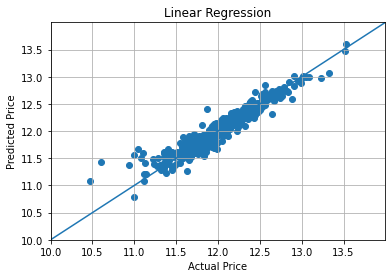

In [14]:
X = X[numeric_features_columns]
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]

model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y, using only the 56 numerical features.

In [15]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns] 
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives an **RMSE score of 0.14234**.